# Imprts and parsing setup


In [ ]:
#imports for data parsing analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import glob
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Statistical analysis
from scipy.stats import mannwhitneyu, kruskal, spearmanr

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

All libraries imported successfully!
Working directory: c:\Users\Ishaan\Documents\GitHub\CMC\154proj


In [ ]:
def parse_model_name(model_name):

    # Pattern for new format: N[number]rv[number]rg[number]Z[number]
    pattern = r'N([\d\.]+)rv([\d\.]+)rg([\d\.]+)Z([\d\.]+)'
    match = re.match(pattern, model_name)
    
    if match:
        return {
            'N': float(match.group(1)),
            'rv': float(match.group(2)), 
            'rg': float(match.group(3)),
            'Z': float(match.group(4)),
            'model_name': model_name
        }
    else:
        print(f"Warning: Could not parse {model_name}")
        return None


In [ ]:
def discover_models(data_directory, filter_rv=True, max_rv=1.0):

    model_dirs = []
    
    for item in os.listdir(data_directory):
        item_path = os.path.join(data_directory, item)
        if os.path.isdir(item_path):
            parsed = parse_model_name(item)
            if parsed:
                parsed['path'] = item_path
                model_dirs.append(parsed)
    
    models_df = pd.DataFrame(model_dirs)
    
    if models_df.empty:
        print("No valid models found!")
        return models_df
    
    # Filter by virial radius if requested
    if filter_rv:
        original_count = len(models_df)
        models_df = models_df[models_df['rv'] < max_rv].copy()
        print(f"Found {original_count} total models, {len(models_df)} with rv < {max_rv}")
    
    # Add some derived parameters for analysis
    models_df['log_N'] = np.log10(models_df['N'])
    models_df['log_Z'] = np.log10(models_df['Z'])
    
    return models_df


## loading individual files

In [ ]:
def load_merger_data_fixed(model_path):

    merger_file = os.path.join(model_path, 'initial.semergedisrupt.log')
    if not os.path.exists(merger_file):
        return None
    
    data = {
        'time': [],
        'interaction_type': [],
        'id_rem': [],
        'mass_rem': [],
        'id1': [],
        'm1': [],
        'id2': [],
        'm2': [],
        'r': [],
        'type_rem': [],
        'type1': [],
        'type2': []
    }
    
    try:
        with open(merger_file, 'r') as file:
            for line in file:
                if line.startswith('t='):
                    # Extract time
                    time_match = re.search(r't=([\d.eE+-]+)', line)
                    # Extract interaction type (disrupt1, disrupt2, merge, etc.)
                    type_match = re.search(r'\s(disrupt1|disrupt2|disruptboth|merge)\s', line)
                    # Extract id_rem and mass_rem (for disruptions)
                    id_rem_match = re.search(r'id_rem=(\d+)\(mass_rem=([\d.eE+-]+)\)', line)
                    # Extract id1 and m1
                    id1_m1_match = re.search(r'id1=(\d+)\(m1=([\d.eE+-]+)\)', line)
                    # Extract id2 and m2  
                    id2_m2_match = re.search(r'id2=(\d+)\(m2=([\d.eE+-]+)\)', line)
                    # Extract r
                    r_match = re.search(r'\(r=([\d.eE+-]+)\)', line)
                    # Extract type_rem, type1, type2
                    type_rem_match = re.search(r'type_rem=(\d+)', line)
                    type1_match = re.search(r'type1=(\d+)', line)
                    type2_match = re.search(r'type2=(\d+)', line)
                    
                    # Only proceed if we have the essential matches
                    if time_match and id1_m1_match and id2_m2_match:
                        data['time'].append(float(time_match.group(1)))
                        data['interaction_type'].append(type_match.group(1) if type_match else 'unknown')
                        
                        # Handle remnant data (may be missing for some interaction types)
                        if id_rem_match:
                            data['id_rem'].append(int(id_rem_match.group(1)))
                            data['mass_rem'].append(float(id_rem_match.group(2)))
                        else:
                            data['id_rem'].append(-1)  # Use -1 for missing data
                            data['mass_rem'].append(0.0)
                        
                        data['id1'].append(int(id1_m1_match.group(1)))
                        data['m1'].append(float(id1_m1_match.group(2)))
                        data['id2'].append(int(id2_m2_match.group(1)))
                        data['m2'].append(float(id2_m2_match.group(2)))
                        data['r'].append(float(r_match.group(1)) if r_match else 0.0)
                        data['type_rem'].append(int(type_rem_match.group(1)) if type_rem_match else -1)
                        data['type1'].append(int(type1_match.group(1)) if type1_match else -1)
                        data['type2'].append(int(type2_match.group(1)) if type2_match else -1)
        
        return pd.DataFrame(data) if data['time'] else None
        
    except Exception as e:
        print(f"Error loading merger data: {e}")
        return None


In [ ]:
def load_bh_formation_data_fixed(model_path):

    # Look for BH formation files
    possible_files = [
        'initial.bheformation.dat',
        'initial.bhformation.dat', 
        'initial.bh.dat'
    ]
    
    for filename in possible_files:
        filepath = os.path.join(model_path, filename)
        if os.path.exists(filepath):
            try:
                # Read all lines manually to handle variable columns
                data_rows = []
                with open(filepath, 'r') as f:
                    for line in f:
                        if not line.startswith('#') and line.strip():
                            # Split and take only first 9 columns
                            parts = line.strip().split()
                            if len(parts) >= 9:
                                data_rows.append(parts[:9])
                
                if data_rows:
                    # Standard column names for first 9 columns
                    columns = ['time', 'r', 'binary', 'ID', 'zams_m', 
                              'm_progenitor', 'bh_mass', 'bh_spin', 'birth_kick']
                    
                    df = pd.DataFrame(data_rows, columns=columns)
                    
                    # Convert to numeric, handling any remaining issues
                    numeric_cols = ['time', 'r', 'zams_m', 'm_progenitor', 
                                   'bh_mass', 'bh_spin', 'birth_kick']
                    for col in numeric_cols:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
                    
                    df['binary'] = pd.to_numeric(df['binary'], errors='coerce').astype(int)
                    df['ID'] = pd.to_numeric(df['ID'], errors='coerce').astype(int)
                    
                    return df, filename
                
            except Exception as e:
                print(f"Error loading {filename}: {e}")
                continue
    
    return None, None


In [ ]:
def load_collision_data_fixed(model_path):

    collision_file = os.path.join(model_path, 'initial.collision.log')
    if not os.path.exists(collision_file):
        return None
    
    data = {
        'time': [], 'collision_type': [], 'idm': [], 'mm': [],
        'id1': [], 'm1': [], 'id2': [], 'm2': [], 'r': [],
        'typem': [], 'type1': [], 'type2': []
    }
    
    try:
        with open(collision_file, 'r') as file:
            for line in file:
                if line.startswith('t='):
                    # Your working regex patterns
                    time_match = re.search(r't=([\d.eE+-]+)', line)
                    type_match = re.search(r'\s(binary-[a-z]+|single-single)\s', line)
                    idm_mm_match = re.search(r'idm=(\d+)\(mm=([\d.eE+-]+)\)', line)
                    id1_m1_match = re.search(r'id1=(\d+)\(m1=([\d.eE+-]+)\)', line)
                    id2_m2_match = re.search(r'id2=(\d+)\(m2=([\d.eE+-]+)\)', line)
                    r_match = re.search(r'\(r=([\d.eE+-]+)\)', line)
                    typem_match = re.search(r'typem=(\d+)', line)
                    type1_match = re.search(r'type1=(\d+)', line)
                    type2_match = re.search(r'type2=(\d+)', line)
                    
                    if all([time_match, type_match, idm_mm_match, id1_m1_match, 
                           id2_m2_match, r_match, typem_match, type1_match, type2_match]):
                        data['time'].append(float(time_match.group(1)))
                        data['collision_type'].append(type_match.group(1))
                        data['idm'].append(int(idm_mm_match.group(1)))
                        data['mm'].append(float(idm_mm_match.group(2)))
                        data['id1'].append(int(id1_m1_match.group(1)))
                        data['m1'].append(float(id1_m1_match.group(2)))
                        data['id2'].append(int(id2_m2_match.group(1)))
                        data['m2'].append(float(id2_m2_match.group(2)))
                        data['r'].append(float(r_match.group(1)))
                        data['typem'].append(int(typem_match.group(1)))
                        data['type1'].append(int(type1_match.group(1)))
                        data['type2'].append(int(type2_match.group(1)))
        
        return pd.DataFrame(data) if data['time'] else None
        
    except Exception as e:
        print(f"Error loading collision data: {e}")
        return None

## Generating derrived features

In [ ]:
def analyze_bh_formation_pathways(bh_data, collision_data, merger_data):

    if bh_data is None or len(bh_data) == 0:
        return {
            'total_bhs': 0,
            'from_collisions': 0,
            'from_mergers': 0,
            'from_normal': 0,
            'collision_percentage': 0,
            'merger_percentage': 0,
            'normal_percentage': 0
        }
    
    total_bhs = len(bh_data)
    bh_ids = set(bh_data['ID'].values)
    
    # Find BHs formed from collisions
    collision_product_ids = set()
    if collision_data is not None and len(collision_data) > 0:
        collision_product_ids = set(collision_data['idm'].values)
    
    # Find BHs formed from mergers  
    merger_product_ids = set()
    if merger_data is not None and len(merger_data) > 0:
        # For mergers, the product typically retains one of the original IDs
        merger_product_ids = set(merger_data['id1'].values) | set(merger_data['id2'].values)
    
    # Categorize BHs
    bhs_from_collisions = bh_ids & collision_product_ids
    bhs_from_mergers = bh_ids & merger_product_ids
    bhs_from_normal = bh_ids - bhs_from_collisions - bhs_from_mergers
    
    results = {
        'total_bhs': total_bhs,
        'from_collisions': len(bhs_from_collisions),
        'from_mergers': len(bhs_from_mergers), 
        'from_normal': len(bhs_from_normal),
        'collision_percentage': (len(bhs_from_collisions) / total_bhs * 100) if total_bhs > 0 else 0, #Presvents parsing empty files
        'merger_percentage': (len(bhs_from_mergers) / total_bhs * 100) if total_bhs > 0 else 0,
        'normal_percentage': (len(bhs_from_normal) / total_bhs * 100) if total_bhs > 0 else 0,
        'collision_ids': bhs_from_collisions,
        'merger_ids': bhs_from_mergers
    }
    
    return results

In [ ]:
def analyze_bh_locations(bh_data, model_params):

    if bh_data is None or len(bh_data) == 0:
        return {
            'mean_formation_radius': 0,
            'median_formation_radius': 0,
            'core_fraction': 0,
            'outer_fraction': 0
        }
    
    formation_radii = bh_data['r'].values
    
    # Define core vs outer regions (somewhat )
    # Core typically < 1 pc, outer > 5 pc for these cluster scales
    core_threshold = 1.0  # pc
    outer_threshold = 5.0  # pc
    
    core_bhs = (formation_radii < core_threshold).sum()
    outer_bhs = (formation_radii > outer_threshold).sum()
    total_bhs = len(formation_radii)
    
    return {
        'mean_formation_radius': formation_radii.mean(),
        'median_formation_radius': np.median(formation_radii),
        'std_formation_radius': formation_radii.std(),
        'core_fraction': (core_bhs / total_bhs * 100) if total_bhs > 0 else 0,
        'outer_fraction': (outer_bhs / total_bhs * 100) if total_bhs > 0 else 0,
        'formation_radii': formation_radii
    }


# Testing above code


In [9]:
# Test the discovery
models_df = discover_models("data", max_rv=1.1)
print(f"Discovered {len(models_df)} models for analysis")
print("\nParameter ranges:")
for param in ['N', 'rv', 'rg', 'Z']:
    print(f"{param}: {models_df[param].min():.3f} - {models_df[param].max():.3f}")


Found 149 total models, 75 with rv < 1.1
Discovered 75 models for analysis

Parameter ranges:
N: 0.800 - 32.000
rv: 0.500 - 1.000
rg: 2.000 - 20.000
Z: 0.000 - 0.020


In [41]:
# Test the fixed loading on one model
test_model = models_df.iloc[0]
print(f"Testing data loading on: {test_model['model_name']}")

bh_data, bh_file = load_bh_formation_data_fixed(test_model['path'])
collision_data = load_collision_data_fixed(test_model['path'])
merger_data = load_merger_data_fixed(test_model['path'])

print(f"BH data: {len(bh_data) } rows from {bh_file}")
print(f"Collision data: {len(collision_data) } rows")
print(f"Merger data: {len(merger_data) if merger_data is not None else 0} rows")

print("BH data columns:", bh_data.columns.tolist())
print("First few BH masses:", bh_data['bh_mass'].head().tolist())


Testing data loading on: N0.81rv0.75rg20Z0.002
BH data: 2162 rows from initial.bhformation.dat
Collision data: 452 rows
Merger data: 0 rows
BH data columns: ['time', 'r', 'binary', 'ID', 'zams_m', 'm_progenitor', 'bh_mass', 'bh_spin', 'birth_kick']
First few BH masses: [40.5, 40.5, 40.5, 664.443, 40.5]


In [ ]:
# Test the analysis functions
pathways = analyze_bh_formation_pathways(bh_data, collision_data, merger_data)
locations = analyze_bh_locations(bh_data, test_model) 

print("BH Formation Pathway Analysis:")
print(f"Total BHs: {pathways['total_bhs']}")
print(f"From collisions: {pathways['from_collisions']} ({pathways['collision_percentage']:.1f}%)")
print(f"From mergers: {pathways['from_mergers']} ({pathways['merger_percentage']:.1f}%)")
print(f"From normal evolution: {pathways['from_normal']} ({pathways['normal_percentage']:.1f}%)")

print(f"BH Location Analysis:")
print(f"Mean formation radius: {locations['mean_formation_radius']:.2f} pc")
print(f"Median formation radius: {locations['median_formation_radius']:.2f} pc")
print(f"Core formation fraction: {locations['core_fraction']:.1f}%")
print(f"Outer formation fraction: {locations['outer_fraction']:.1f}%")
#Note: I started the project more focused on formation location but soon dropped it as the results weren't particularly interesting in hindsight

BH Formation Pathway Analysis:
Total BHs: 2162
From collisions: 149 (6.9%)
From mergers: 0 (0.0%)
From normal evolution: 2013 (93.1%)

BH Location Analysis:
Mean formation radius: 0.53 pc
Median formation radius: 0.45 pc
Core formation fraction: 91.6%
Outer formation fraction: 0.0%


# Processing models

In [ ]:
def process_single_model(model_info):
    """
    Process a single model and extract all relevant features
    """
    model_path = model_info['path']
    model_name = model_info['model_name']
    
    print(f"Processing: {model_name}")
    
    # Load all data types
    bh_data, bh_file = load_bh_formation_data_fixed(model_path)
    collision_data = load_collision_data_fixed(model_path)
    merger_data = load_merger_data_fixed(model_path)
    
    # Basic model parameters
    features = {
        'model_name': model_name,
        'N': model_info['N'],
        'rv': model_info['rv'],
        'rg': model_info['rg'],
        'Z': model_info['Z'],
        'log_N': model_info['log_N'],
        'log_Z': model_info['log_Z']
    }
    
    # BH formation pathway analysis
    pathways = analyze_bh_formation_pathways(bh_data, collision_data, merger_data)
    features.update({
        'total_bhs': pathways['total_bhs'],
        'bhs_from_collisions': pathways['from_collisions'],
        'bhs_from_mergers': pathways['from_mergers'],
        'bhs_from_normal': pathways['from_normal'],
        'collision_percentage': pathways['collision_percentage'],
        'merger_percentage': pathways['merger_percentage'],
        'normal_percentage': pathways['normal_percentage']
    })
    
    # BH properties
    if bh_data is not None and len(bh_data) > 0:
        features.update({
            'mean_bh_mass': bh_data['bh_mass'].mean(),
            'max_bh_mass': bh_data['bh_mass'].max(),
            'std_bh_mass': bh_data['bh_mass'].std(),
            'mean_bh_spin': bh_data['bh_spin'].mean(),
            'max_bh_spin': bh_data['bh_spin'].max(),
            'spin_count': (bh_data['bh_spin'] > 0).sum(),
            'formation_efficiency': pathways['total_bhs'] / model_info['N'] * 100000,  #Note that the outputs from this function were always suspicious so I stopped caring about it later on and switched to merger rate 
            'non_zero_spin_mean': bh_data.loc[bh_data['bh_spin'] > 0, 'bh_spin'].mean()
        })
        
        # Location analysis
        locations = analyze_bh_locations(bh_data, model_info)
        features.update({
            'mean_formation_radius': locations['mean_formation_radius'],
            'median_formation_radius': locations['median_formation_radius'],
            'core_formation_fraction': locations['core_fraction'],
            'outer_formation_fraction': locations['outer_fraction']
        })
    else:
        # Zero values for models with no BHs
        features.update({
            'mean_bh_mass': 0, 'max_bh_mass': 0, 'std_bh_mass': 0,
            'mean_bh_spin': 0, 'max_bh_spin': 0, 'spin_count': 0,
            'formation_efficiency': 0, 'mean_formation_radius': 0,
            'median_formation_radius': 0, 'core_formation_fraction': 0,
            'outer_formation_fraction': 0
        })
    
    # Collision and merger statistics
    features.update({
        'total_collisions': len(collision_data) if collision_data is not None else 0,
        'total_mergers': len(merger_data) if merger_data is not None else 0,
        'collision_rate': (len(collision_data) / model_info['N'] * 1000) if collision_data is not None else 0,
        'merger_rate': (len(merger_data) / model_info['N'] * 1000) if merger_data is not None else 0
    })
    
    return features

In [13]:
def process_all_models(models_df, max_models=None):
    """
    Process all models and create comprehensive dataset
    """
    if max_models:
        models_to_process = models_df.head(max_models)
    else:
        models_to_process = models_df
    
    all_results = []
    
    for idx, model_info in models_to_process.iterrows():
        try:
            result = process_single_model(model_info)
            all_results.append(result)
        except Exception as e:
            print(f"Error processing {model_info['model_name']}: {e}")
            continue
    
    return pd.DataFrame(all_results)

## testing model processing

In [ ]:
results_df = process_all_models(models_df, max_models=200)
results_df['high_spin_fraction'] = (results_df['spin_count'] / results_df['total_bhs'] * 100).fillna(0)
print(results_df.columns)
print(f"Processed {len(results_df)} models successfully")
print(f"Dataset shape: {results_df.shape}")

Processing: N0.81rv0.75rg20Z0.002
Processing: N0.81rv1rg20Z0.002
Processing: N0.8rv0.75rg20Z0.002
Processing: N0.8rv1rg20Z0.002
Processing: N16rv0.5rg2.0Z0.002
Processing: N16rv0.5rg2.0Z0.02
Processing: N16rv0.5rg20.0Z0.002
Processing: N16rv0.5rg20.0Z0.02
Processing: N16rv0.5rg8.0Z0.002
Processing: N16rv0.5rg8.0Z0.02
Processing: N16rv1.0rg2.0Z0.0002
Processing: N16rv1.0rg2.0Z0.002
Processing: N16rv1.0rg2.0Z0.02
Processing: N16rv1.0rg20.0Z0.0002
Processing: N16rv1.0rg20.0Z0.002
Processing: N16rv1.0rg20.0Z0.02
Processing: N16rv1.0rg8.0Z0.0002
Processing: N16rv1.0rg8.0Z0.002
Processing: N16rv1.0rg8.0Z0.02
Processing: N2.0rv0.5rg2.0Z0.0002
Processing: N2.0rv0.5rg2.0Z0.002
Processing: N2.0rv0.5rg2.0Z0.02
Processing: N2.0rv0.5rg20.0Z0.0002
Processing: N2.0rv0.5rg20.0Z0.002
Processing: N2.0rv0.5rg20.0Z0.02
Processing: N2.0rv0.5rg8.0Z0.0002
Processing: N2.0rv0.5rg8.0Z0.002
Processing: N2.0rv0.5rg8.0Z0.02
Processing: N2.0rv1.0rg2.0Z0.0002
Processing: N2.0rv1.0rg2.0Z0.002
Processing: N2.0rv1.0rg

In [ ]:
useful_columns = [col for col in results_df.columns if col not in ['model_name', 'log_N', 'log_Z','N','rv','rg']] 
#include logs?

In [37]:
# Calculate comprehensive statistics so I can get an idea of the data set
stats_summary = results_df[useful_columns].describe()

print("COMPREHENSIVE STATISTICS FOR CMC GLOBULAR CLUSTER ANALYSIS")
print("=" * 80)
print(f"Total models analyzed: {len(results_df)}")
print("\nDETAILED STATISTICS:")
print(stats_summary.round(3))

COMPREHENSIVE STATISTICS FOR CMC GLOBULAR CLUSTER ANALYSIS
Total models analyzed: 75

DETAILED STATISTICS:
            Z  total_bhs  bhs_from_collisions  bhs_from_mergers  \
count  75.000     75.000               75.000            75.000   
mean    0.007   1433.133              337.507           192.093   
std     0.009   1179.348              438.884           146.860   
min     0.000    269.000               11.000             0.000   
25%     0.000    488.000               69.500            86.000   
50%     0.002   1238.000              194.000           172.000   
75%     0.020   2250.000              420.500           289.000   
max     0.020   6427.000             1901.000           758.000   

       bhs_from_normal  collision_percentage  merger_percentage  \
count           75.000                75.000             75.000   
mean           945.733                24.027             16.067   
std            919.461                20.861              7.519   
min             72.00

In [ ]:

#Distribution Information

print(f"KEY INSIGHTS:")
print(f"Parameter Ranges:")
print(f"  N (stellar population): {results_df['N'].min():.1f}k - {results_df['N'].max():.1f}k stars")
print(f"  Virial radius: {results_df['rv'].min():.2f} - {results_df['rv'].max():.2f}")
print(f"  Gravitational radius: {results_df['rg'].min():.1f} - {results_df['rg'].max():.1f}")
print(f"  Metallicity: {results_df['Z'].min():.6f} - {results_df['Z'].max():.6f}")

print(f"Black Hole Formation:")
print(f"  Total BHs across all models: {results_df['total_bhs'].sum():.0f}")
print(f"  Average BHs per model: {results_df['total_bhs'].mean():.1f} ± {results_df['total_bhs'].std():.1f}")
print(f"  Formation efficiency: {results_df['formation_efficiency'].mean():.2f} ± {results_df['formation_efficiency'].std():.2f} BHs/100000 stars")

print(f"Formation Pathways:")
print(f"  From collisions: {results_df['collision_percentage'].mean():.1f}% ± {results_df['collision_percentage'].std():.1f}%")
print(f"  From mergers: {results_df['merger_percentage'].mean():.1f}% ± {results_df['merger_percentage'].std():.1f}%")
print(f"  From normal evolution: {results_df['normal_percentage'].mean():.1f}% ± {results_df['normal_percentage'].std():.1f}%")

print(f"Black Hole Properties:")
print(f"  Mean BH mass: {results_df['mean_bh_mass'].mean():.1f} ± {results_df['mean_bh_mass'].std():.1f} M☉")
print(f"  Maximum BH mass: {results_df['max_bh_mass'].max():.1f} M☉")
print(f"  Mean maximum BH spin: {results_df['max_bh_spin'].mean():.3f} ± {results_df['mean_bh_spin'].std():.3f}")
print(f" MEean Spin count: {results_df['spin_count'].mean():.1f}% ± {results_df['spin_count'].std():.1f}%")

print(f"Spatial Distribution:")
print(f"  Mean formation radius: {results_df['mean_formation_radius'].mean():.2f} ± {results_df['mean_formation_radius'].std():.2f} pc")
print(f"  Core formation: {results_df['core_formation_fraction'].mean():.1f}% ± {results_df['core_formation_fraction'].std():.1f}%")

print(f"Dynamical Activity:")
print(f"  Collision rate: {results_df['collision_rate'].mean():.2f} ± {results_df['collision_rate'].std():.2f} per 1000 stars")
print(f"  Merger rate: {results_df['merger_rate'].mean():.2f} ± {results_df['merger_rate'].std():.2f} per 1000 stars")

KEY INSIGHTS:
Parameter Ranges:
  N (stellar population): 0.8k - 32.0k stars
  Virial radius: 0.50 - 1.00
  Gravitational radius: 2.0 - 20.0
  Metallicity: 0.000200 - 0.020000
Black Hole Formation:
  Total BHs across all models: 107485
  Average BHs per model: 1433.1 ± 1179.3
  Formation efficiency: 313791.75 ± 588173.42 BHs/100000 stars
Formation Pathways:
  From collisions: 24.0% ± 20.9%
  From mergers: 16.1% ± 7.5%
  From normal evolution: 63.4% ± 21.1%
Black Hole Properties:
  Mean BH mass: 14.0 ± 4.8 M☉
  Maximum BH mass: 664.4 M☉
  Mean maximum BH spin: 0.046 ± 0.000
 MEean Spin count: 0.1% ± 0.4%
Spatial Distribution:
  Mean formation radius: 0.75 ± 0.13 pc
  Core formation: 77.1% ± 8.7%
Dynamical Activity:
  Collision rate: 653585.96 ± 432397.11 per 1000 stars
  Merger rate: 536634.00 ± 173735.85 per 1000 stars


# Now we analyze


In [18]:
print(f"\nSpin analysis:")
print(f"Models with any spinning BHs: {(results_df['spin_count'] > 0).sum()}")
print(f"Mean high-spin fraction: {results_df['high_spin_fraction'].mean():.3f}%")


Spin analysis:
Models with any spinning BHs: 5
Mean high-spin fraction: 0.009%


## Metalicity effects analysis


In [28]:
def analyze_metallicity_effects(df):

    print("METALLICITY EFFECTS ON BLACK HOLE FORMATION")
    print("=" * 60)
    
    # Create metallicity bins
    df['Z_category'] = pd.cut(df['Z'], bins=3, labels=['Low Z', 'Medium Z', 'High Z'])
    
    # Group by metallicity
    z_groups = df.groupby('Z_category')
    
    print(f"\nMetallicity Group Analysis:")
    for name, group in z_groups:
        if len(group) > 0:
            print(f"\n{name} (Z = {group['Z'].min():.6f} - {group['Z'].max():.6f}):")
            print(f"  Models: {len(group)}")
            print(f"  Mean BH count: {group['total_bhs'].mean():.1f} ± {group['total_bhs'].std():.1f}")
            print(f"  Collision formation: {group['collision_percentage'].mean():.1f}% ± {group['collision_percentage'].std():.1f}%")
            print(f"  Merger formation: {group['merger_percentage'].mean():.1f}% ± {group['merger_percentage'].std():.1f}%")
            print(f"  Mean BH mass: {group['mean_bh_mass'].mean():.1f} ± {group['mean_bh_mass'].std():.1f} M☉")
    
    

    # Correlation analysis
    z_correlations = {
        'BH Count': df['Z'].corr(df['total_bhs']),
        'Collision %': df['Z'].corr(df['collision_percentage']),
        'Merger %': df['Z'].corr(df['merger_percentage']),
        'Mean BH Mass': df['Z'].corr(df['mean_bh_mass'])
    }
    
    print(f"\nCorrelations with Metallicity:")
    for property_name, correlation in z_correlations.items():
        significance = "**" if abs(correlation) > 0.3 else "*" if abs(correlation) > 0.2 else ""
        print(f"  {property_name}: {correlation:.3f} {significance}")
    
    return df

# Run metallicity analysis
results_df = analyze_metallicity_effects(results_df)


METALLICITY EFFECTS ON BLACK HOLE FORMATION

Metallicity Group Analysis:

Low Z (Z = 0.000200 - 0.002000):
  Models: 50
  Mean BH count: 1494.0 ± 1197.3
  Collision formation: 23.7% ± 21.7%
  Merger formation: 15.5% ± 7.8%
  Mean BH mass: 17.1 ± 2.5 M☉

High Z (Z = 0.020000 - 0.020000):
  Models: 25
  Mean BH count: 1311.5 ± 1157.0
  Collision formation: 24.6% ± 19.5%
  Merger formation: 17.2% ± 6.9%
  Mean BH mass: 7.8 ± 0.2 M☉

Correlations with Metallicity:
  BH Count: -0.072 
  Collision %: 0.050 
  Merger %: 0.102 
  Mean BH Mass: -0.935 **


In [ ]:
def perform_pca_analysis(df):

    # Select features for PCA
    feature_cols = ['N', 'rv', 'rg', 'Z', 'total_bhs', 
                   'collision_percentage', 'merger_percentage', 'mean_bh_mass',
                   'mean_formation_radius', 'collision_rate', 'merger_rate','high_spin_fraction','spin_count', 'median_formation_radius']
    
    # Prepare data
    X = df[feature_cols].fillna(0)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Create results
    pca_df = pd.DataFrame(X_pca[:, :5], columns=[f'PC{i+1}' for i in range(5)])
    
    print("PCA ANALYSIS RESULTS")
    print("=" * 40)
    print(f"Components needed for 95% variance: {np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0][0] + 1}")
    print(f"First 5 components explain: {pca.explained_variance_ratio_[:5].sum():.1%} of variance")
    
    # Feature loadings
    loadings = pd.DataFrame(
        pca.components_[:3].T,
        columns=['PC1', 'PC2', 'PC3'],
        index=feature_cols
    )
    
    print(f"\nPC1 ({pca.explained_variance_ratio_[0]:.1%} variance) - Top loadings:")
    pc1_loadings = loadings['PC1'].abs().sort_values(ascending=False)
    for feature, loading in pc1_loadings.head(4).items():
        print(f"  {feature}: {loading:.3f}")
    
    print(f"\nPC2 ({pca.explained_variance_ratio_[1]:.1%} variance) - Top loadings:")
    pc2_loadings = loadings['PC2'].abs().sort_values(ascending=False)
    for feature, loading in pc2_loadings.head(4).items():
        print(f"  {feature}: {loading:.3f}")
    
    return pca_df, pca, scaler, feature_cols

# Perform PCA
pca_results, pca_model, pca_scaler, pca_features = perform_pca_analysis(results_df)


PCA ANALYSIS RESULTS
Components needed for 95% variance: 7
First 5 components explain: 85.9% of variance

PC1 (33.8% variance) - Top loadings:
  rv: 0.433
  median_formation_radius: 0.423
  collision_rate: 0.382
  collision_percentage: 0.382

PC2 (19.2% variance) - Top loadings:
  Z: 0.502
  mean_bh_mass: 0.489
  spin_count: 0.459
  high_spin_fraction: 0.439


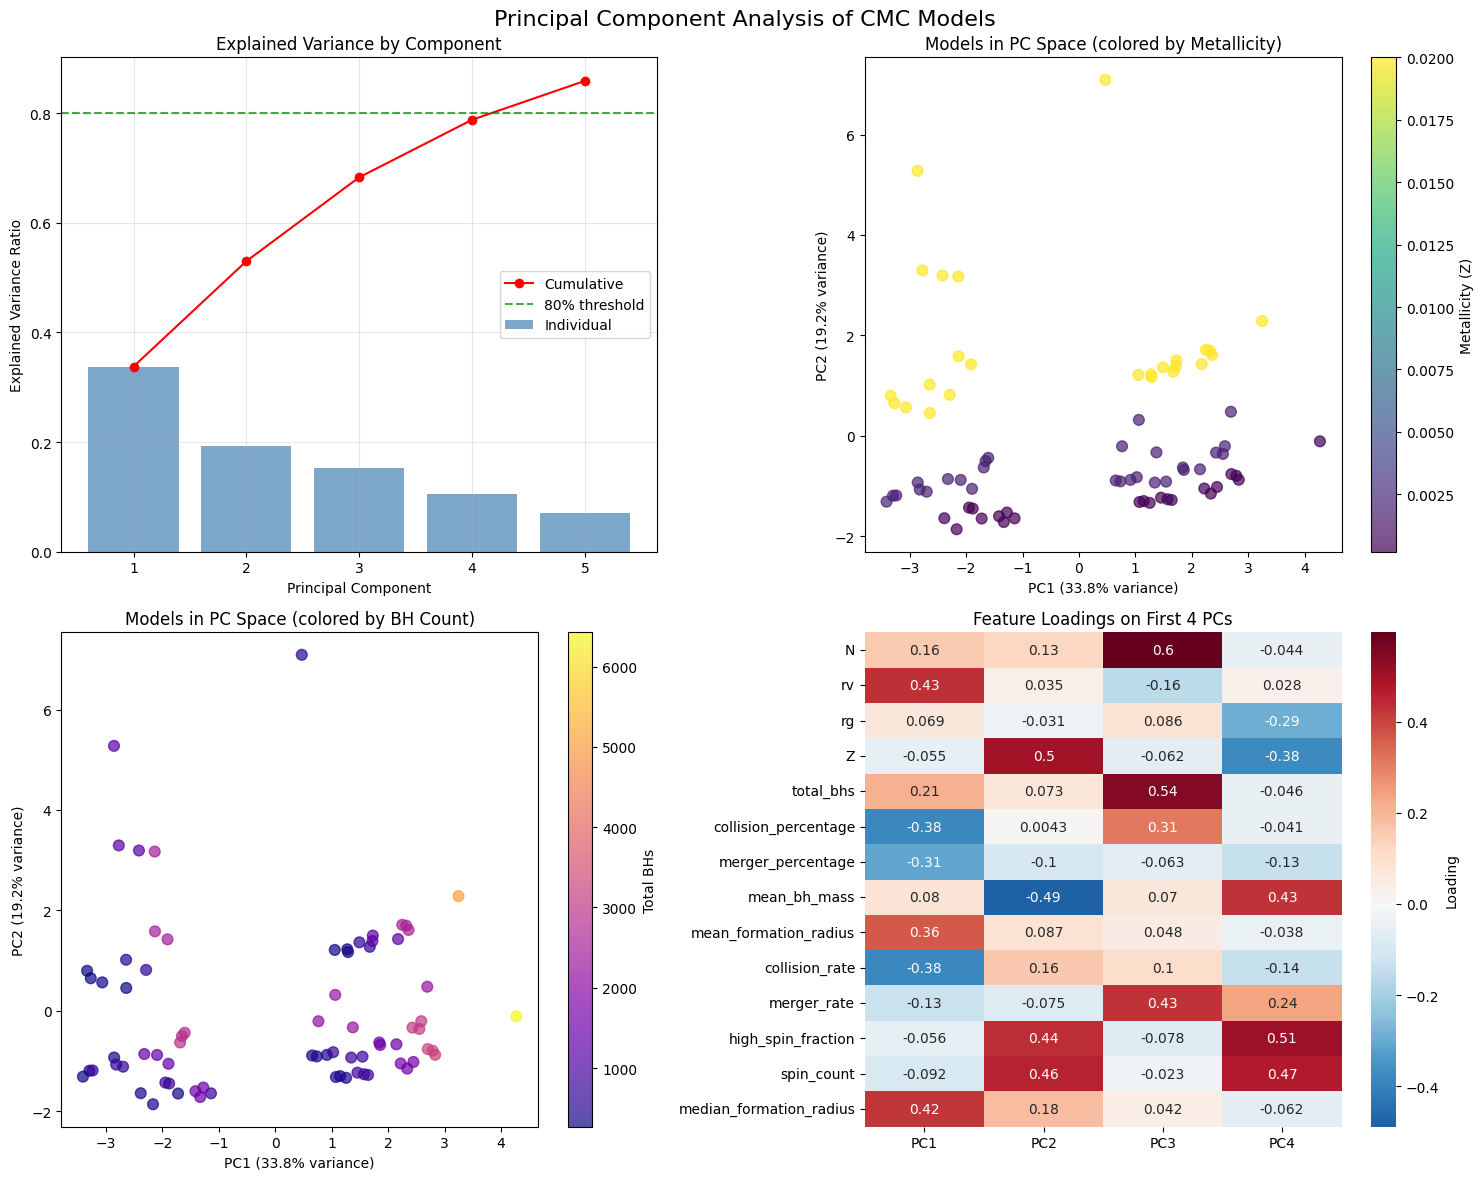

In [21]:
# Create PCA visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Principal Component Analysis of CMC Models', fontsize=16)

# Explained variance
ax = axes[0, 0]
explained_var = pca_model.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
ax.bar(range(1, 6), explained_var[:5], alpha=0.7, color='steelblue', label='Individual')
ax.plot(range(1, 6), cumulative_var[:5], 'ro-', color='red', label='Cumulative')
ax.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='80% threshold')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Explained Variance by Component')
ax.legend()
ax.grid(True, alpha=0.3)

# PC1 vs PC2 colored by metallicity
ax = axes[0, 1]
scatter = ax.scatter(pca_results['PC1'], pca_results['PC2'], 
                    c=results_df['Z'], cmap='viridis', alpha=0.7, s=60)
ax.set_xlabel(f'PC1 ({explained_var[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({explained_var[1]:.1%} variance)')
ax.set_title('Models in PC Space (colored by Metallicity)')
plt.colorbar(scatter, ax=ax, label='Metallicity (Z)')

# PC1 vs PC2 colored by BH count
ax = axes[1, 0]
scatter = ax.scatter(pca_results['PC1'], pca_results['PC2'], 
                    c=results_df['total_bhs'], cmap='plasma', alpha=0.7, s=60)
ax.set_xlabel(f'PC1 ({explained_var[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({explained_var[1]:.1%} variance)')
ax.set_title('Models in PC Space (colored by BH Count)')
plt.colorbar(scatter, ax=ax, label='Total BHs')

# Feature loadings heatmap
ax = axes[1, 1]
loadings = pd.DataFrame(
    pca_model.components_[:4].T,
    columns=[f'PC{i+1}' for i in range(4)],
    index=pca_features
)
sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0, ax=ax, 
           cbar_kws={'label': 'Loading'})
ax.set_title('Feature Loadings on First 4 PCs')

plt.tight_layout()
plt.show()


In [ ]:
def perform_clustering_analysis(pca_results, results_df):

    #K-means clustering to identify distinct cluster populations

    # Use first 3 PCs for clustering
    X_cluster = pca_results[['PC1', 'PC2', 'PC3']].values
    
    # Find optimal number of clusters
    silhouette_scores = []
    K_range = range(2, 8)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_cluster)
        score = silhouette_score(X_cluster, cluster_labels)
        silhouette_scores.append(score)
    
    optimal_k = K_range[np.argmax(silhouette_scores)]
    
    # Final clustering
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_cluster)
    
    # Add to dataframe
    results_df['cluster'] = cluster_labels
    
    print("CLUSTERING ANALYSIS")
    print("=" * 40)
    print(f"Optimal number of clusters: {optimal_k}")
    print(f"Silhouette score: {max(silhouette_scores):.3f}")
    
   
    
    return cluster_labels, kmeans_final, optimal_k

# Perform clustering
cluster_labels, cluster_model, n_clusters = perform_clustering_analysis(pca_results, results_df)


CLUSTERING ANALYSIS
Optimal number of clusters: 3
Silhouette score: 0.479


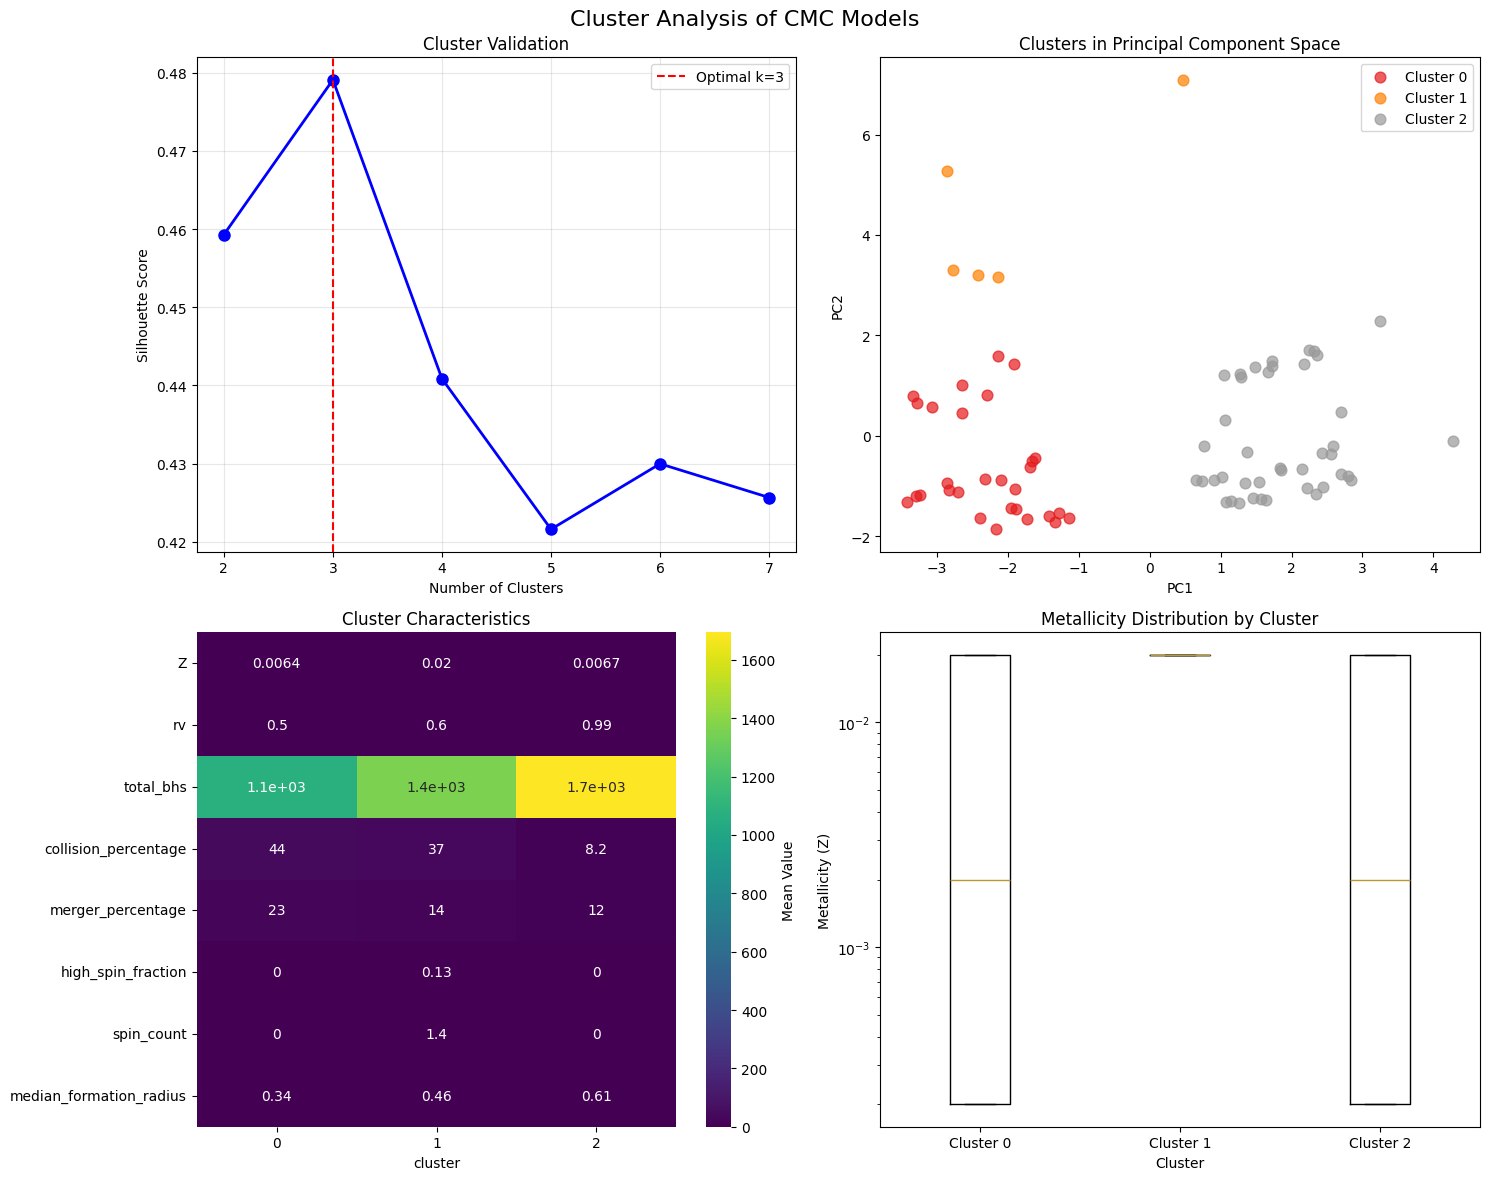

In [23]:
# Create clustering visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Cluster Analysis of CMC Models', fontsize=16)

# Silhouette scores
ax = axes[0, 0]
K_range = range(2, 8)
silhouette_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pca_results[['PC1', 'PC2', 'PC3']])
    score = silhouette_score(pca_results[['PC1', 'PC2', 'PC3']], labels)
    silhouette_scores.append(score)

ax.plot(K_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
ax.axvline(x=n_clusters, color='red', linestyle='--', label=f'Optimal k={n_clusters}')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title('Cluster Validation')
ax.legend()
ax.grid(True, alpha=0.3)

# Clusters in PC space
ax = axes[0, 1]
colors = plt.cm.Set1(np.linspace(0, 1, n_clusters))
for i in range(n_clusters):
    mask = results_df['cluster'] == i
    ax.scatter(pca_results.loc[mask, 'PC1'], pca_results.loc[mask, 'PC2'],
              c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=60)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Clusters in Principal Component Space')
ax.legend()

# Cluster characteristics heatmap
ax = axes[1, 0]
cluster_features = ['Z', 'rv', 'total_bhs',  
                   'collision_percentage', 'merger_percentage','high_spin_fraction','spin_count', 'median_formation_radius']
cluster_means = results_df.groupby('cluster')[cluster_features].mean()
sns.heatmap(cluster_means.T, annot=True, cmap='viridis', ax=ax,
           cbar_kws={'label': 'Mean Value'})
ax.set_title('Cluster Characteristics')

# Metallicity distribution by cluster
ax = axes[1, 1]
cluster_z_data = [results_df[results_df['cluster'] == i]['Z'] for i in range(n_clusters)]
ax.boxplot(cluster_z_data, labels=[f'Cluster {i}' for i in range(n_clusters)])
ax.set_xlabel('Cluster')
ax.set_ylabel('Metallicity (Z)')
ax.set_yscale('log')
ax.set_title('Metallicity Distribution by Cluster')

plt.tight_layout()
plt.show()


In [ ]:
def perform_random_forest_classification(df):

    #Random Forest to predict high BH merger rate efficiency
 
    # Create target variable - high formation efficiency (top 30%)
    efficiency_threshold = df['merger_percentage'].quantile(0.7)
    df['high_efficiency'] = (df['merger_percentage'] >= efficiency_threshold).astype(int)
    
    print("RANDOM FOREST CLASSIFICATION")
    print("=" * 40)
    print(f"Target: Merger Percentage efficiency (>{efficiency_threshold:.1f} )")
    print(f"High efficiency models: {df['high_efficiency'].sum()} ({df['high_efficiency'].mean():.1%})")
    
    # Features for prediction
    pred_features = ['N', 'rv', 'rg', 'Z']
    X = df[pred_features]
    y = df['high_efficiency']
    
    # Check class balance
    if y.nunique() < 2:
        print("Warning: Only one class present - cannot perform classification")
        return None, None
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Train Random Forest
    rf_classifier = RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        class_weight='balanced',
        max_depth=5  # Prevent overfitting with small dataset
    )
    rf_classifier.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_classifier.predict(X_test)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    
    # Cross-validation
    cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
    
    # Results
    accuracy = (y_pred == y_test).mean()
    print(f"\nClassification Results:")
    print(f"Test accuracy: {accuracy:.3f}")
    print(f"Cross-validation score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    # Feature importance
    importances = pd.Series(rf_classifier.feature_importances_, 
                           index=pred_features).sort_values(ascending=False)
    print(f"\nFeature Importance:")
    for feature, importance in importances.items():
        print(f"  {feature}: {importance:.3f}")
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return rf_classifier, importances

# Perform classification
rf_model, feature_importance = perform_random_forest_classification(results_df)


RANDOM FOREST CLASSIFICATION
Target: Merger Percentage efficiency (>15.8 )
High efficiency models: 23 (30.7%)

Classification Results:
Test accuracy: 0.957
Cross-validation score: 0.885 ± 0.072

Feature Importance:
  rv: 0.542
  N: 0.336
  Z: 0.071
  rg: 0.050

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.88      1.00      0.93         7

    accuracy                           0.96        23
   macro avg       0.94      0.97      0.95        23
weighted avg       0.96      0.96      0.96        23



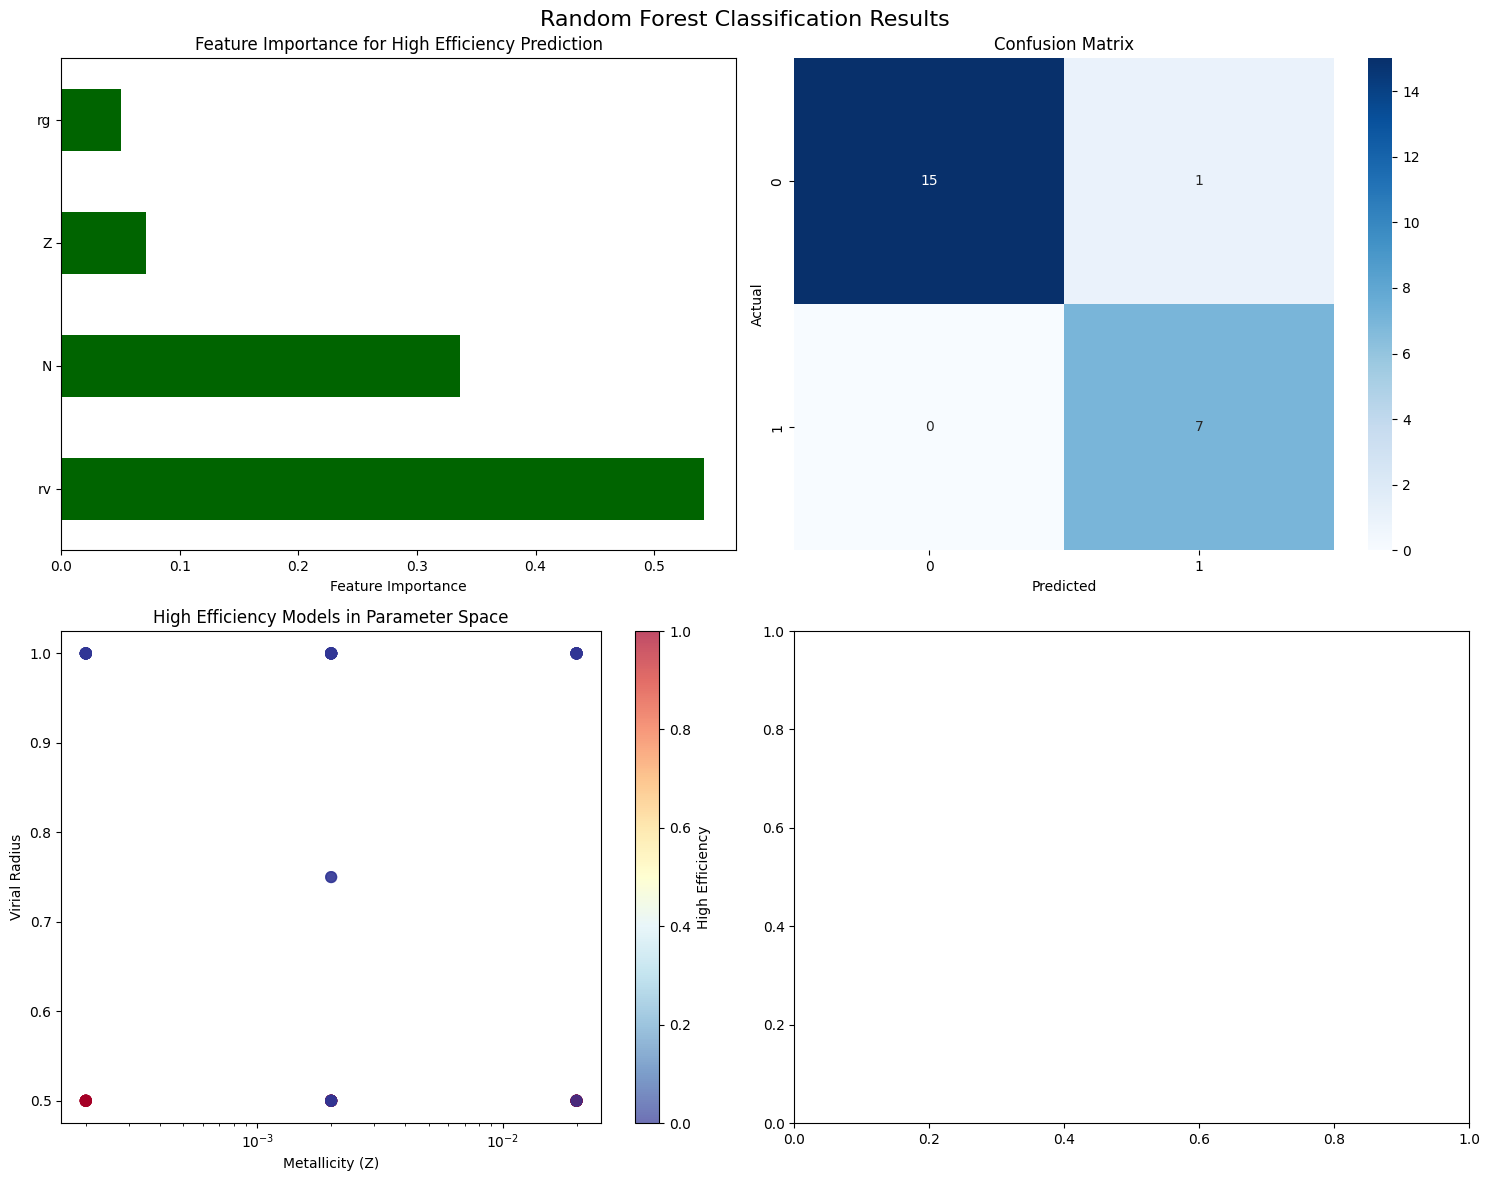

In [35]:

# Create classification visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Classification Results', fontsize=16)
    
# Feature importance
ax = axes[0, 0]
feature_importance.plot(kind='barh', ax=ax, color='darkgreen')
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importance for High Efficiency Prediction')
    
# Confusion matrix
ax = axes[0, 1]
pred_features = ['N', 'rv', 'rg', 'Z']
X = results_df[pred_features]
y = results_df['high_efficiency']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
y_pred = rf_model.predict(X_test)
    
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
    
# Parameter space with predictions
ax = axes[1, 0]
scatter = ax.scatter(results_df['Z'], results_df['rv'], 
                        c=results_df['high_efficiency'], cmap='RdYlBu_r', alpha=0.7, s=60)
ax.set_xlabel('Metallicity (Z)')
ax.set_ylabel('Virial Radius')
ax.set_xscale('log')
ax.set_title('High Efficiency Models in Parameter Space')
plt.colorbar(scatter, ax=ax, label='High Efficiency')
    

    
plt.tight_layout()
plt.show()


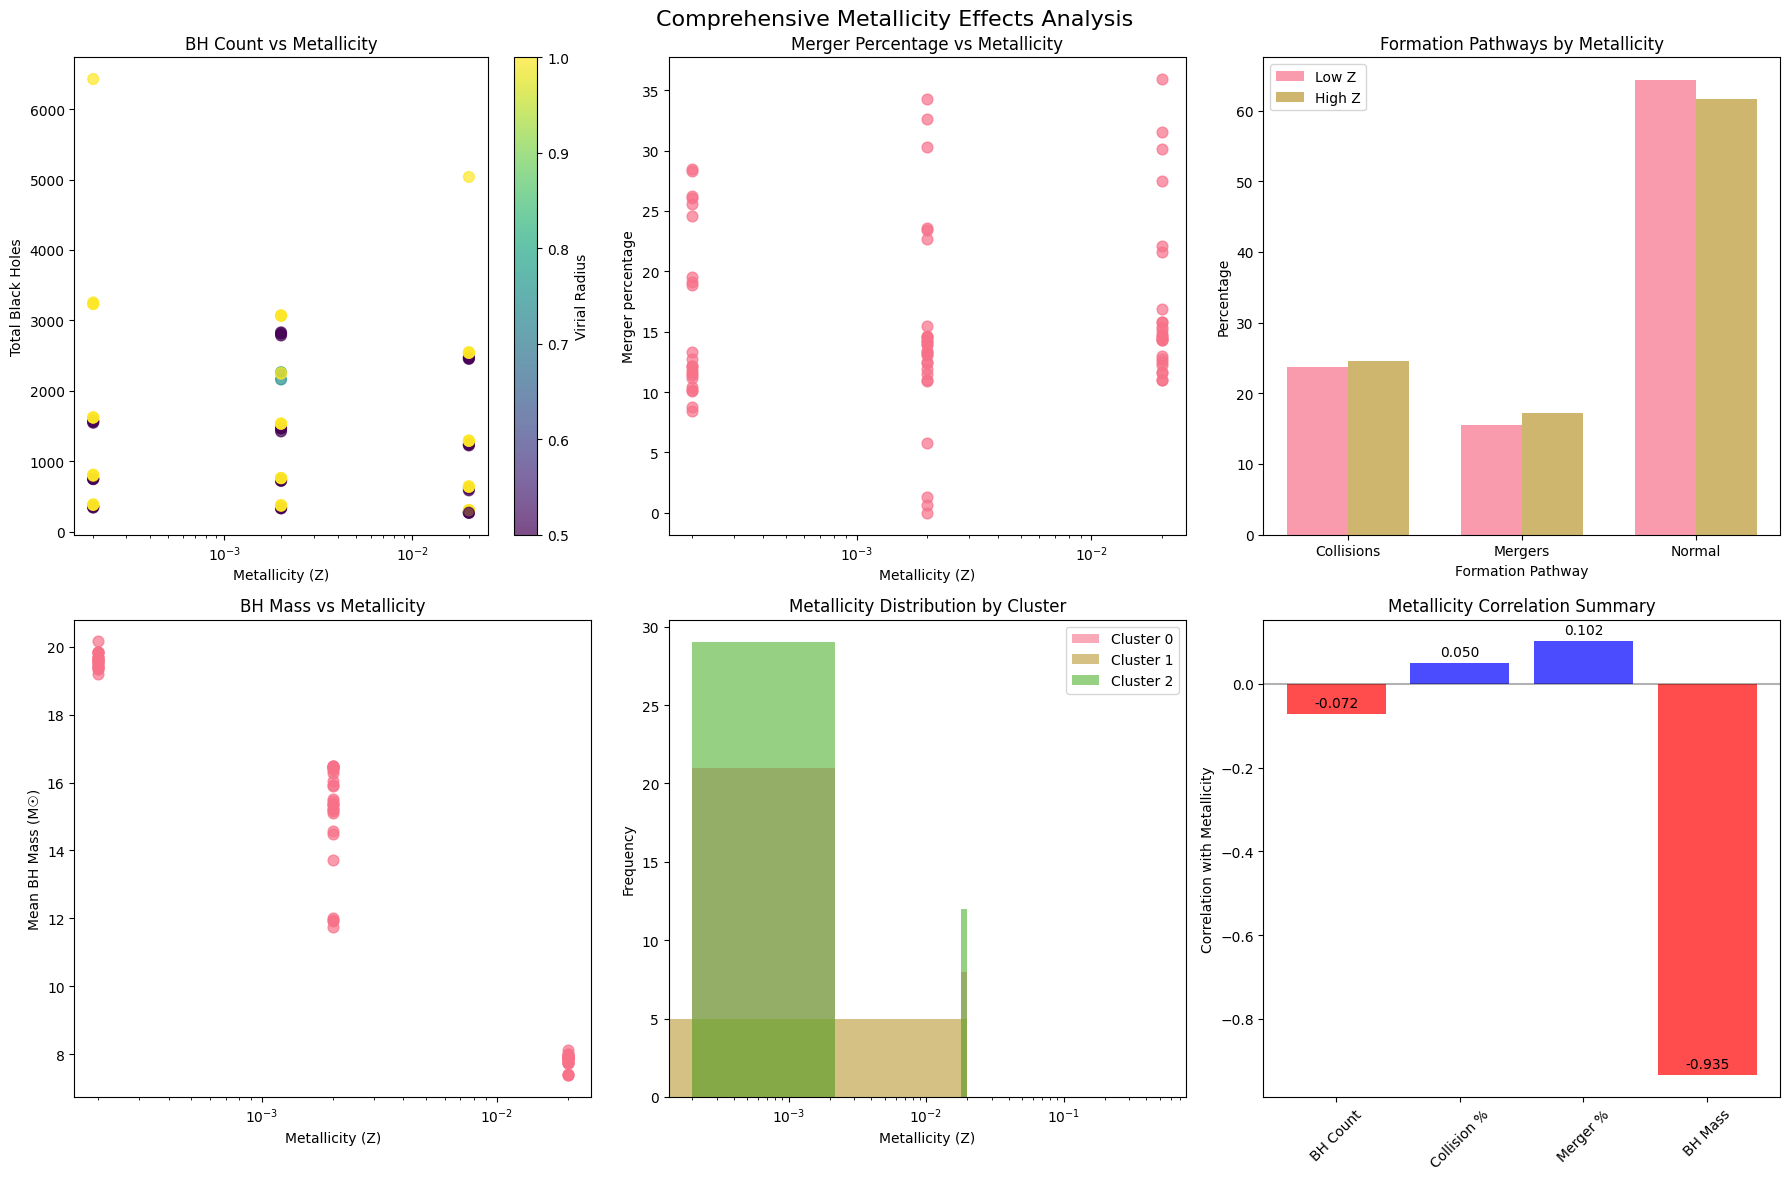

In [33]:
# Create comprehensive metallicity analysis plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Metallicity Effects Analysis', fontsize=16)

# BH count vs metallicity
ax = axes[0, 0]
scatter = ax.scatter(results_df['Z'], results_df['total_bhs'], 
                    c=results_df['rv'], cmap='viridis', alpha=0.7, s=60)
ax.set_xlabel('Metallicity (Z)')
ax.set_ylabel('Total Black Holes')
ax.set_xscale('log')
ax.set_title('BH Count vs Metallicity')
plt.colorbar(scatter, ax=ax, label='Virial Radius')

# Merger percentage vs metallicity
ax = axes[0, 1]
ax.scatter(results_df['Z'], results_df['merger_percentage'], 
             alpha=0.7, s=60)
ax.set_xlabel('Metallicity (Z)')
ax.set_ylabel('Merger percentage')
ax.set_xscale('log')
ax.set_title('Merger Percentage vs Metallicity')

# Formation pathways vs metallicity
ax = axes[0, 2]
low_z = results_df[results_df['Z'] <= results_df['Z'].median()]
high_z = results_df[results_df['Z'] > results_df['Z'].median()]

pathway_low = [low_z['collision_percentage'].mean(), 
               low_z['merger_percentage'].mean(), 
               low_z['normal_percentage'].mean()]
pathway_high = [high_z['collision_percentage'].mean(), 
                high_z['merger_percentage'].mean(), 
                high_z['normal_percentage'].mean()]

x = np.arange(3)
width = 0.35
ax.bar(x - width/2, pathway_low, width, label='Low Z', alpha=0.7)
ax.bar(x + width/2, pathway_high, width, label='High Z', alpha=0.7)
ax.set_xlabel('Formation Pathway')
ax.set_ylabel('Percentage')
ax.set_title('Formation Pathways by Metallicity')
ax.set_xticks(x)
ax.set_xticklabels(['Collisions', 'Mergers', 'Normal'])
ax.legend()

# BH mass vs metallicity
ax = axes[1, 0]
ax.scatter(results_df['Z'], results_df['mean_bh_mass'], alpha=0.7, s=60)
ax.set_xlabel('Metallicity (Z)')
ax.set_ylabel('Mean BH Mass (M☉)')
ax.set_xscale('log')
ax.set_title('BH Mass vs Metallicity')

# Metallicity distribution by cluster
ax = axes[1, 1]
if 'cluster' in results_df.columns:
    for i in range(n_clusters):
        cluster_data = results_df[results_df['cluster'] == i]
        ax.hist(cluster_data['Z'], bins=10, alpha=0.6, label=f'Cluster {i}')
    ax.set_xlabel('Metallicity (Z)')
    ax.set_ylabel('Frequency')
    ax.set_xscale('log')
    ax.set_title('Metallicity Distribution by Cluster')
    ax.legend()

# Correlation summary
ax = axes[1, 2]
correlations = {
    'BH Count': results_df['Z'].corr(results_df['total_bhs']),
    'Collision %': results_df['Z'].corr(results_df['collision_percentage']),
    'Merger %': results_df['Z'].corr(results_df['merger_percentage']),
    'BH Mass': results_df['Z'].corr(results_df['mean_bh_mass'])
}

bars = ax.bar(range(len(correlations)), list(correlations.values()), 
             color=['red' if x < 0 else 'blue' for x in correlations.values()], alpha=0.7)
ax.set_xticks(range(len(correlations)))
ax.set_xticklabels(correlations.keys(), rotation=45)
ax.set_ylabel('Correlation with Metallicity')
ax.set_title('Metallicity Correlation Summary')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add correlation values on bars
for bar, value in zip(bars, correlations.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
           f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
